## Initialization

In [100]:
#!pip install opencv-python
import os # For directories 
import numpy as np 
import pandas as pd
from skimage import io 
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
#from skimage.morphology import (closing, square erosion, dilation, opening, area_closing, area_opening)
from skimage.morphology import (closing, square, erosion, dilation, closing, opening,
                                area_closing, area_opening)
from math import exp
from skimage.color import label2rgb, rgb2gray
from skimage.io import imread, imshow
from skimage.filters import difference_of_gaussians, gaussian
from skimage.draw import disk
from scipy import misc
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline 
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()  
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout
from ipywidgets.embed import embed_minimal_html, dependency_state
from scipy import stats
from scipy.optimize import curve_fit
from pathlib import Path, PureWindowsPath # for working with windows paths
import tifffile # library to store numpy arrays in TIFF
#import cv2 # to label connected components in binarized images 
import csv # Importation and exportation of settings
#import xarray

## Step 0: Choose Directoy, File, & Set Independent Variables

In [101]:
working_directory = r"X:\Hunter\FRAP_Movie" #Change from X to Z as needed #Z:\Hunter\GoodFRAP
filename = r"Tag_scFv_FRAP8488.tif" # FRAP7_488.tif

working_directory = r"X:\Hunter\GoodFRAP" #Change from X to Z as needed #Z:\Hunter\GoodFRAP
filename = r"7_488_BetterRegistered.tif" # FRAP7_488.tif

In [238]:
# Parameters needed for describing the FRAP experiment
pixel_size = 0.130          #microns; 130nm for flexie and ## on confocal
dt1 = 0.5                   #seconds; the time between frames right after FRAP at faster post-FRAP frame rate
dt2 = 5                     #seconds; the time between frames at slower post-FRAP frame rate
change_t_frame_num = 50     #unitless; the frame number at which the frame rate changes from dt1 to dt2 
frap_frame_num = 20         #unitless; the frame number at which you did the FRAP photobleach
bleach_dt = 0.1             #seconds; the time it took to do the FRAP
radial_bin_size = 2         #pixels; the width in pixels of concentric rings that describe the FRAP spot through time
buffer = 3                  #not sure right now
fit_up_to = 6               #how many concentric rings around FRAP spot to fit
frap_channel = 0            #0 for single-channel movie; 1 or 2 for two-channel movie

In [103]:
#Consider writing settings as objects
def exportSettings(export_filename, export_directory=working_directory):
    settingsEx = [[pixel_size],[dt1],[dt2],[change_t_frame_num],[frap_frame_num],[bleach_dt],[radial_bin_size],[buffer],[fit_up_to],[frap_channel]]
    with open(os.path.join(export_directory, export_filename), 'w', newline = '') as csvfile:
        file_writer = csv.writer(csvfile)
        file_writer.writerows(settingsEx)
    return 1
def importSettings(import_filename, import_directory=working_directory):
    settings = []
    try:
        settings_file = open(os.path.join(import_directory,import_filename),'r')
        try:
            file_reader = csv.reader(settings_file)
            for setting in file_reader:
                settings.append(setting)
            settings = [float(i[0]) for i in settings]
            intIndices = [2,3,4,6,7,8,9]
            for i in intIndices:
                settings[i] = int(settings[i])
        except:
            print("Settings file opened but reading failed")
            return []
        finally:
            settings_file.close()
    except:
        print("Unable to open settings file")
        return []
    return settings

In [104]:
#exportSettings(r"test_settings.csv", working_directory)
#pixel_size,dt1,dt2,change_t_frame_num,frap_frame_num,bleach_dt,radial_bin_size,buffer,fit_up_to,frap_channel = importSettings(r"test_settings.csv", working_directory)

# Step 1: Find position of cell and FRAP spot; subtract background

In [105]:
vid = imread(os.path.join(working_directory,filename)) 

In [106]:
(frame_num, dim_x, dim_y) = vid.shape
[frame_num, dim_x, dim_y]

[289, 244, 306]

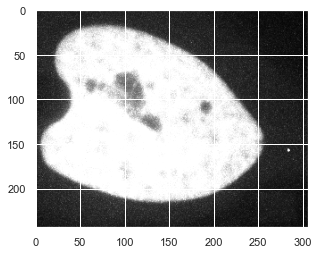

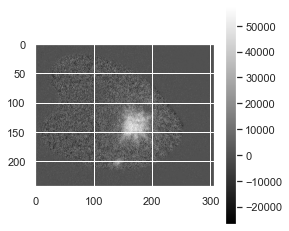

In [107]:
# To estimate where the FRAP occurred, we will take the difference between the FRAP frame and the previous frame:
# colormap options are: 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean',
#print(frame_num)

#GET MASK FOR ENTIRE NUCLEUS (MAX PROJECTION)
plt.imshow(np.max(vid,axis=0), cmap='gray')

diff_arr = np.mean(vid[frap_frame_num-5:frap_frame_num-1], axis =0) - np.mean(vid[frap_frame_num:frap_frame_num+5], axis = 0) #Difference between FRAP frame and previous frame #Which indices? adding colons
plt.figure(figsize=(4,4))
#plt.imshow(diff_arr,cmap= 'gray')  
plt.imshow(diff_arr,cmap= 'gray')  
plt.colorbar()
plt.show()

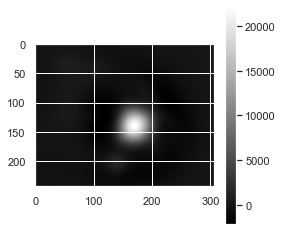

In [131]:
# Performing difference of gaussian to accentuate FRAP spot
filtered_arr = difference_of_gaussians(diff_arr, 12, 40)
plt.figure(figsize=(4,4))
plt.imshow(filtered_arr,cmap= 'gray')  
plt.colorbar()
plt.show()

In [132]:
# Finding the intensity of pixels in the 99% percentile (top 1% of pixels by brightness)
frap_threshhold = np.quantile(filtered_arr,0.99)

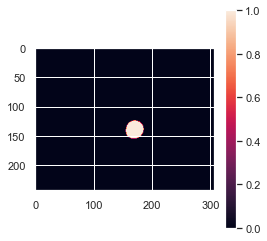

In [196]:
binarized_arr = filtered_arr.copy()
binarized_arr[filtered_arr < frap_threshhold] = 0
binarized_arr[filtered_arr >= frap_threshhold] = 1
plt.figure(figsize=(4,4))
plt.imshow(binarized_arr)  
plt.colorbar()
plt.show()

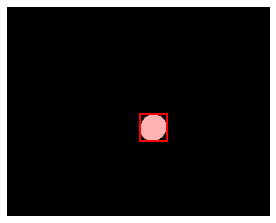

In [111]:
# remove artifacts connected to image border
cleared = clear_border(binarized_arr)

# label image regions
label_image = label(cleared)

# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=filtered_arr, bg_label=0)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    #Regionprops, check circularity DO THIS HUNTER
    if region.area >= 300:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [112]:
center = np.array(region.centroid).astype('int16')

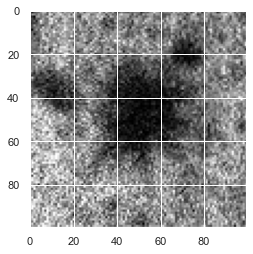

In [113]:
plt.imshow(vid[frap_frame_num, center[0]-50:center[0]+50, center[1]-50:center[1]+50], cmap = 'gray')

In [114]:
[region.bbox for region in regionprops(label_image)]

[(125, 155, 156, 186)]

(23, 50)


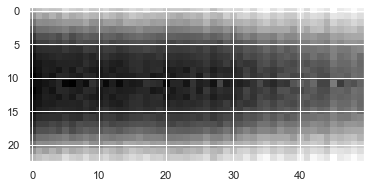

In [115]:
#GET CONCENTRIC CIRCLES AND MAP ACROSS TIME
def getCircles(im, center, num_circles, radius, exclusive = True):
    ret_arr = np.zeros((num_circles,radius,radius))
    rad_arr = np.linspace(radius/num_circles,radius,num=num_circles)
    #print(rad_arr)
    #print(disk(center,rad_arr[1],shape = im.shape)[0])
    #print(crop_im.shape)
    ret_arr = [disk(center,i,shape = vid.shape) for i in rad_arr] #Determine how to align crop_im and center
    #Worth attempting to coerce to np array?
    '''for i in range(len(rad_arr)):
        labels = disk(center,rad_arr(i),shape = im.shape)
        ret_arr[i,labels]'''
    #print(ret_arr.shape)
    '''if exclusive:
        temp_arr = ret_arr.copy()#np.vstack()
        for i in range(len(ret_arr[0]),1,-1)
            for j in range(len(i)):
                #if ret_arr[i][j][0] == ret_arr[i-1][j][0]
                3
        #ret_arr = 
        np.vstack((tp, fp)).T''' #will fix by averaging brightness values
    
    #ret_arr[disk(center,i,shape = im.shape) for i in rad_arr] = 1
    #print(ret_arr[0])
    return(ret_arr)

def frapFramePlot(im, circle_arr, full = True):
    #bright_arr = np.array(((len(circle_arr)*2)+1))
    bright_arr = [np.mean(im[i]) for i in circle_arr]
    for i in range(len(circle_arr)-1, 0, -1):
        #print("Iter" + str(i))
        #print(len(circle_arr[i]))
        #print(len(circle_arr[i-1]))
        bright_arr[i] = (bright_arr[i] * len(circle_arr[i][0]) - bright_arr[i-1] * len(circle_arr[i-1][0]))/(len(circle_arr[i][0])-len(circle_arr[i-1][0]))
    #bright_arr.append(bright_arr[:-2]) #Reverse array as well #Only half currently
    if full:
        bright_arr = np.concatenate((bright_arr[:0:-1], bright_arr))
    return (bright_arr)
def frapTimeLapse(im, center, num_circles, radius, start_frame, num_frames, full = True):
        if full:
            time_arr = np.zeros(((num_circles*2)-1,num_frames))
        else:
            time_arr = np.zeros((num_circles,num_frames))
        print(time_arr.shape)
        for i in range(start_frame, start_frame + num_frames):
            time_arr[:,i-start_frame] = frapFramePlot(im[i], getCircles(im[i], center, num_circles, radius), full = full)
        #bright_sum = 
        #for(i in )
        #frame_arr = np.arange(start_frame,)
        #getCircles(im[frame], center, num_circles, radius)
        plt.imshow(time_arr, cmap = 'gray')
        return time_arr
#temp = getCircles(vid[frap_frame_num, center[0]-50:center[0]+50, center[1]-50:center[1]+50], center, 8, 50)
#tempVals = frapFramePlot(vid[frap_frame_num], temp)
test = frapTimeLapse(vid, center, 12, 24, frap_frame_num, 50)
#tempVals = [np.mean(vid[i]) for i in temp]
#print(temp[0])
#print(type(temp))
#print(test)
#print(tempVals)

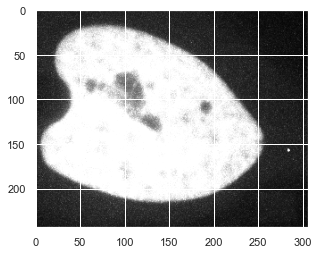

In [116]:
#APPLY GAUSSIAN FILTER TO MAX PROJECTION
max_projection = np.amax(vid, axis = 0)
plt.imshow(max_projection, cmap = 'gray')
#np.amax(vid)
gaussian_max = gaussian(max_projection)
#plt.imshow(gaussian_max, cmap = 'gray')

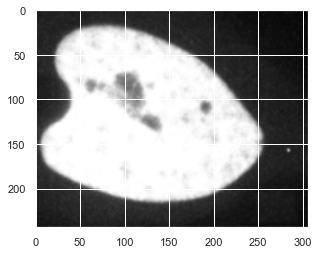

In [117]:
plt.imshow(gaussian_max, cmap = 'gray')

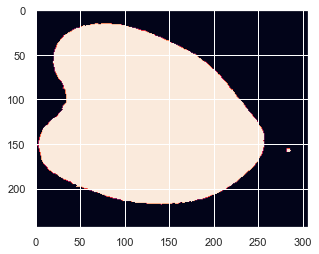

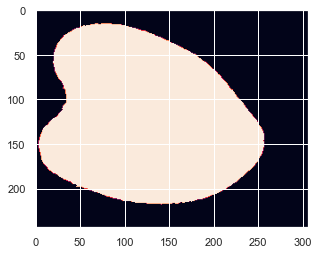

37313.0


In [242]:
#REGION PROP FILL HOLES IN MATRIX
#Utilize centroid to fill others? 
bin_gauss_max_threshold = np.quantile(gaussian_max,0.5)
bin_gauss_max = gaussian_max.copy()
bin_gauss_max[gaussian_max < bin_gauss_max_threshold] = 0
bin_gauss_max[gaussian_max > bin_gauss_max_threshold] = 1
#ax.imshow(bin_gauss_max, cmap = 'gray')



cleared = clear_border(bin_gauss_max)

# label image regions
gauss_label_image = label(cleared)

gauss_label_overlay = label2rgb(gauss_label_image, image=bin_gauss_max, bg_label=0)

test_image_filling = bin_gauss_max.copy()
#print(test_image_filling)
plt.imshow(test_image_filling)
plt.show()
regionSize = 0
for region in regionprops(gauss_label_image):
    # take regions with large enough areas
    #Regionprops, check circularity DO THIS HUNTER
    #print(dir(region))
    #print(region.filled_area)
    #print(region.perimeter)
    #print(region.bbox)
    #print(region.intensity_image)
    #for property, value in vars(region).items():
        #print(property, ":", value)
    #break
    #print(region)
    if region.area <= 300:
        # draw rectangle around segmented coins
        #minr, minc, maxr, maxc = region.bbox
        #rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  #fill=False, edgecolor='red', linewidth=2)
        #ax.add_patch(rect)
        #print(region.area)
        #print(f'Region label is {region.label}')
        #print(test_image_filling[gauss_label_image == region.label])
        test_image_filling[gauss_label_image == region.label] = 0
    else:
        region_intensity = np.sum(test_image_filling[gauss_label_image == region.label])
def fillMatrixHoles(im, label_im, min_size, circ_tol = 0.7):
    #circ_tol is equivalent to how 
    region_intensity = 0
    regions = regionprops(label_im)
    for region in regions:
        if (region.area < min_size) & ():
            im[gauss_label_image == region.label] = 0
            #Implement pls
            print("Implement")
        else:
            print("Implement")
plt.imshow(test_image_filling)
plt.show()
print(region_intensity)

(123.37212231661887, 123.66330769436925)
37313
2
17


C:\Users\Hunter\anaconda3\envs\labPython\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


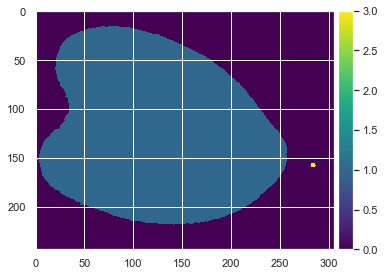

In [130]:
bin_gauss_max_threshold = np.quantile(gaussian_max,0.5)
bin_gauss_max = gaussian_max.copy()
bin_gauss_max[gaussian_max < bin_gauss_max_threshold] = 0
bin_gauss_max[gaussian_max > bin_gauss_max_threshold] = 1

imshow(bin_gauss_max)

cleared = clear_border(bin_gauss_max)

# label image regions
gauss_label_image = label(cleared)

props = regionprops(gauss_label_image, gaussian_max)
print(props[0].centroid)

def checkCircularity(gauss_label_image, region):
    label = region.label


for region in regionprops(gauss_label_image, gaussian_max):
    # take regions with large enough areas
    #Regionprops, check circularity DO THIS HUNTER
    print(region.area)
    if region.area >= 300:
        #gauss_label_image[[[0,1,2],[0,1,2]]] = 1
        #print(np.mean(region.image_intensity))
        temp=3
imshow(gauss_label_image)


In [235]:
#def get_prebleach_intensity(im, label_im, label, frap_frame_num):
    #sum_intensity = np.sum(im[frap_frame_num-1][label_im == label])
    #return sum_intensity
#def get_post_bleach_intensity(im, label_im, label, frap_frame_num):
    #return get_prebleach_intensity(im, label_im, label, frap_frame_num + 1)    

#Fairly computationally intensive, consider if worth doing
def get_quantile_threshold(im): 
    quantile_difs = [-abs(np.mean((np.quantile(im,i-.01),np.quantile(im,i),np.quantile(im,i+.01)))-np.mean((np.quantile(im,i+.02),np.quantile(im,i+.03),np.quantile(im,i+.04)))) for i in np.arange(.05,.95,.01)]
    quantile = np.argmax(quantile_difs)+4
    return np.quantile(im,quantile/100)

def get_frame_nucleus_intensity(im, frame=False):
    if(frame):
        im_frame = im[frame,:,:]
    else:
        im_frame = im
    #threshhold = get_quantile_threshold(im_frame)
    threshold = 0.65
    binarized_arr = np.zeros(im_frame.shape)
    binarized_arr[im_frame >= frap_threshhold] = 1
    
    #imshow(binarized_arr)
    # remove artifacts connected to image border
    cleared = clear_border(binarized_arr)

    # label image regions
    label_image = label(cleared)

    for region in regionprops(label_image):
        # take regions with large enough areas
        #Regionprops, check circularity DO THIS HUNTER
        if region.area >= 300:
            # draw rectangle around segmented coins
            #minr, minc, maxr, maxc = region.bbox
            return(np.sum(im_frame[label_image==region.label]))
    print("No return found")
    return -1


#print(np.max(filtered_arr))
#print(filtered_arr)
#print(get_quantile_threshold(filtered_arr))
#print(np.quantile(filtered_arr,.65))
print(get_frame_nucleus_intensity(vid, frap_frame_num-1))
print(get_frame_nucleus_intensity(vid, frap_frame_num))
#print(np.mean([get_frame_nucleus_intensity(vid,i) for i in np.arange(0,frap_frame_num,1)]))
#print(np.mean([get_frame_nucleus_intensity(vid,i) for i in np.arange(frap_frame_num,200,1)]))


1416861300
1173752502


In [236]:
def get_frap_region_intensity(im, center=center, radius=25,label_im=False,label=False):
    if(label_im and label):
        return np.mean(im[label_im==label])
    '''if(center and radius):
        return np.mean(np.mean(im[disk(center,radius,shape = im.shape)]))
    binarized_arr = im.copy()
    binarized_arr[filtered_arr < frap_threshhold] = 0
    binarized_arr[filtered_arr >= frap_threshhold] = 1'''
    return np.mean(im[disk(center,radius,shape = im.shape)])

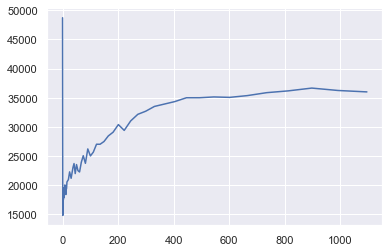

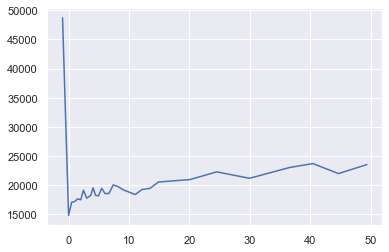

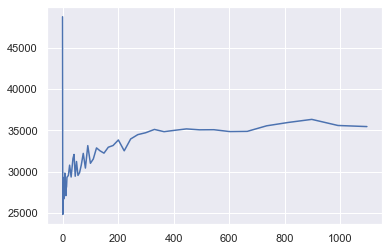

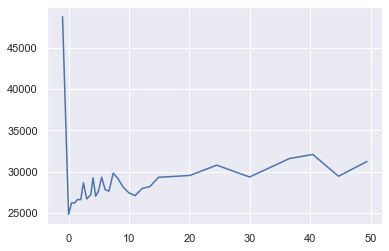

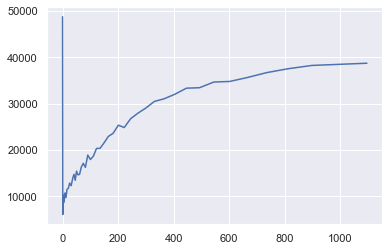

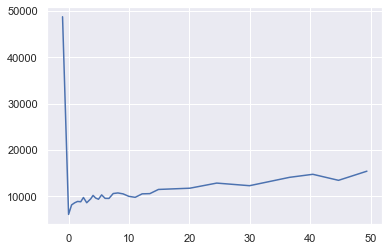

In [237]:
def point_to_time(im, frap_frame_num=frap_frame_num, change_t_frame_num=change_t_frame_num, dt1=dt1, dt2=dt2):
    #times = np.concatenate(np.arange(0,(change_t_frame_num-frap_frame_num)*dt1,dt1),(np.arange(0, (im.shape[0]-change_t_frame_num)*dt2,dt2)+(change_t_frame_num-frap_frame_num)*dt1))
    times = np.arange(0,(change_t_frame_num-frap_frame_num)*dt1,dt1)
    times = np.concatenate((times,(np.arange(0, (im.shape[0]-change_t_frame_num)*dt2,dt2)+(change_t_frame_num-frap_frame_num)*dt1)))
    return times
#print(point_to_time(np.zeros((289,6,6))))

def map_to_time(time_points, exp_points):
    bins = [np.argmax(-abs(exp_points-i)) for i in time_points]
    #binned_points = [time_points[np.argwhere(bins-i == 0)] for i in np.unique(bins)] #if len(time_points[np.argmax(-abs(bins-i))]) != 0]
    binned_points = [np.argwhere(bins-i == 0) for i in np.unique(bins)] #if len(time_points[np.argmax(-abs(bins-i))]) != 0]
    #Produces extra layer of array wrappers which are unnecessary, fixed when used below
    time_plotted = exp_points[np.unique(bins)]
    #print(bins)
    #print(len(binned_points))
    return binned_points,time_plotted

def make_frap_curve(im, rate = 0.1, frap_frame_num=frap_frame_num, change_t_frame_num=change_t_frame_num, dt1=dt1, dt2=dt2, radius=25):

    #exp Whileⅇexp i ≤ Length[myfrap〚1〛] - frapn + 1,
    #explist = Appendexplist, ⅇexp i // Round[#, 1] &;
    # i = i + 1;
    times = point_to_time(im, frap_frame_num, change_t_frame_num, dt1, dt2)
    exp_list = np.concatenate((np.arange(0,1,0.1),[exp(i*rate) for i in range(len(times)) if exp(i*rate) < times[-1]]))
    #print(len(exp_list))
    #print(len(times))
    binned_points,time_points = map_to_time(times, exp_list)

    #intensity_list = [np.mean(map(get_frame_nucleus_intensity,im[i,:,:])) for i in binned_points] #Obviously not correct, need function to get at image frame
    intensity_list = np.zeros((len(binned_points)))
    '''for i in range(len(binned_points)):
        temp_intense = 0
        for j in binned_points[i]:
            temp_intense += get_frame_nucleus_intensity(im,frame = int(j[0])+frap_frame_num)
        print(temp_intense)
        intensity_list[i] = (temp_intense/len(binned_points[i]))'''
    for i in range(len(binned_points)):
        temp_intense = 0
        for j in binned_points[i]:
            temp_intense += get_frap_region_intensity(im[int(j[0])+frap_frame_num,:,:], radius = radius)
        #print(temp_intense)
        intensity_list[i] = (temp_intense/len(binned_points[i]))
    #intensity_list = [get_frap_region_intensity(im[i[0]]) for j in i for i in ]
    return intensity_list,time_points

before_frap_spot = get_frap_region_intensity(vid[frap_frame_num-1,:,:])
frap_curve,frap_times = make_frap_curve(vid)
frap_times = np.concatenate(([-1],frap_times))
frap_curve = np.concatenate(([before_frap_spot],frap_curve))
#print(frap_curve)
plt.plot(frap_times,frap_curve)
plt.show()
plt.plot(frap_times[:30],frap_curve[:30])
plt.show()

frap_curve,frap_times = make_frap_curve(vid, radius = 40)
frap_times = np.concatenate(([-1],frap_times))
frap_curve = np.concatenate(([before_frap_spot],frap_curve))
plt.plot(frap_times,frap_curve)
plt.show()
plt.plot(frap_times[:30],frap_curve[:30])
plt.show()

frap_curve,frap_times = make_frap_curve(vid, radius = 15)
frap_times = np.concatenate(([-1],frap_times))
frap_curve = np.concatenate(([before_frap_spot],frap_curve))
plt.plot(frap_times,frap_curve)
plt.show()
plt.plot(frap_times[:30],frap_curve[:30])
plt.show()
#How to represent on graph if average of multiple points?

In [ ]:
#Symbolic representation of formula: use SymPy

In [ ]:
#READ INTO X ARRAY?


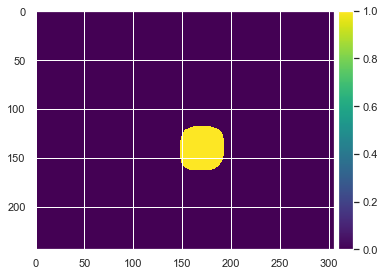

In [ ]:
#https://medium.com/swlh/image-processing-with-python-connected-components-and-region-labeling-3eef1864b951

'''
square = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]])
def multi_dil(im, num, element=square):
    for i in range(num):
        im = dilation(im, element)
    return im
def multi_ero(im, num, element=square):
    for i in range(num):
        im = erosion(im, element)
    return im
multi_dilated = multi_dil(binarized, 7)
area_closed = area_closing(multi_dilated, 50000)
multi_eroded = multi_ero(area_closed, 7)
opened = opening(multi_eroded)
imshow(opened)


label_im = label(opened)
regions = regionprops(label_im)
imshow(label_im)
'''
def label_images(im, dil_num, ero_num=-1, closing_num = 50000, element = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]])):
    if ero_num == -1:
        ero_num = dil_num
    dil_im = im
    for i in range(dil_num):
        dil_im = dilation(dil_im, element)
    close_im = area_closing(dil_im, closing_num)
    ero_im = close_im #Can eliminate redundant variables if not desired for debugging
    for i in range(ero_num):
        eroIm = erosion(ero_im, element)
    
    opened_im = opening(ero_im)
    label_im = label(opened_im)
    return label_im
labeled_im = label_images(binarized_arr, 7);
imshow(labeled_im);

